# Writeup

## First Step: Camera Calibration

The first step in this project was to calibrate the camera images, for this task we were provided with a series of chessboard images, which can be used to compute the distortion coefficients and the correction matrix. Tools to do so are availble in the openCV package.

### Chessboard Images: Sanity Check

To start off, the chessboard images were loaded and checked for sanity.

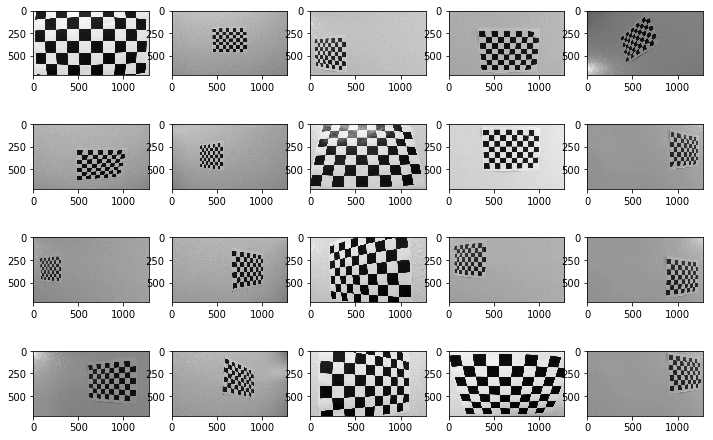

In [1]:
### Load the openCV library, which is responsible
### for the calibration
import cv2

### Load os library, to loop through the path of
### images
from os import listdir
from os.path import isfile, join

### Load matplotlib library to show files
import matplotlib.pyplot as plt
%matplotlib inline

### Import numpy to handle images as arrays
import numpy as np

### Get all files in the destination folder
dest_folder = 'camera_cal'
chessboard_files = [join(dest_folder, f) for f in listdir(dest_folder) if isfile(join(dest_folder, f))]

fig, ax = plt.subplots(4,5, figsize = (12,8))
images = []
for i, file in enumerate(chessboard_files):
    image = np.array(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2GRAY))
    images.append(image)
    ax[i%4, (i-i%4)%5].imshow(image, cmap='gray')

plt.show()

## Calculate the Camera Calibration
The images all show the typical 8x6 chessboard structure. To start off, the basic corner finding algorithm of openCV was applied to all the grayscaled chessboard images. 

In [2]:
### The chessboard has 9 x 6 points, which need to be passed to the Algorithm
nx = 9
ny = 6

### Generate an array of object points, to represent the chessboard corners
objp = np.zeros((nx * ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

### Loop through all the grayscale images and generate object points and corner
### coordinate arrays
objpoints = []
cornerpoints = []
for image in images:
    ret, corners = cv2.findChessboardCorners(image, (nx, ny), None)
    if ret==True:
        objpoints.append(objp)
        cornerpoints.append(corners)

In the next step the openCV function calibrateCamera can be used to calculate the distortion coefficient

In [3]:
cornerpoints = np.array(cornerpoints)
objpoints = np.array(objpoints)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, cornerpoints, images[0].shape[::-1], None, None)

Finally, to check how well we configured the camera, we can test the undistortion on the chessboard images

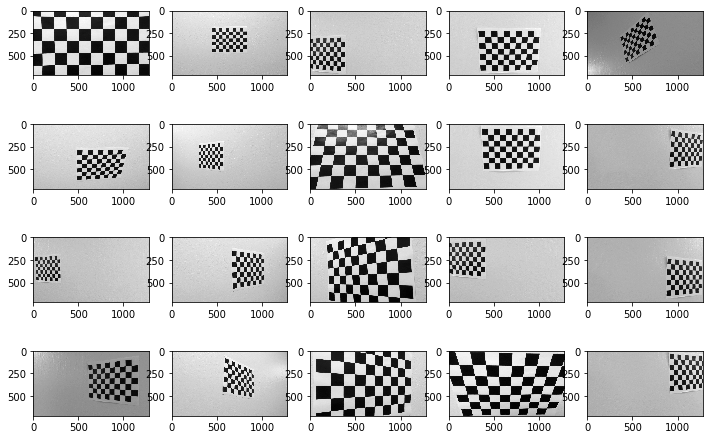

In [4]:
fig, ax = plt.subplots(4,5, figsize = (12,8))
for i, image in enumerate(images):
    ax[i%4, (i-i%4)%5].imshow(cv2.undistort(image, mtx, dist, None, mtx), cmap='gray')

Looks fine for me!

## Second Step: Apply undistortion to the Raw Camera Images

The next step is to inport our Lane Data and apply our un-distort filter to it. For that we've got 8 example images, which we can use to run our Lane Finding Algorithm on.
First things first, we take inthe image data and undistort them

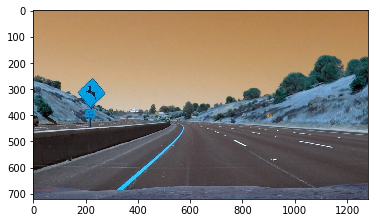

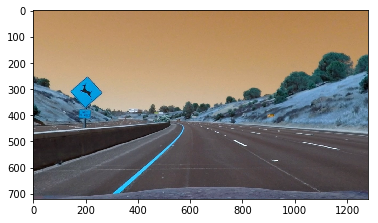

In [5]:
### Get all files in the destination folder
dest_folder = 'test_images'
test_files = [join(dest_folder, f) for f in listdir(dest_folder) if isfile(join(dest_folder, f))]

images = []
for i, file in enumerate(test_files):
    image = np.array(cv2.imread(file))
    images.append(cv2.undistort(image, mtx, dist, None, mtx))
    if i==3:
        plt.imshow(image)
plt.show()
plt.imshow(images[3])
plt.show()

Above we can see both the distorted and undistorted image. Especially close to the borders, the image is clearly corrected, which is an expected  distortion for modern camera. In modern camera lenses tend to bend the light more unprecicely close to the edges, this is why images are most distorted in corner regions.

## Third Step: Transform the Image for Edge Detection

In the next step, the image has to be transformed to yield a better edge detection. The best way to do so is looking at the performance of different approaches and actually combine them in a last step to get most of all the algorithms.

## Perspective Transform

In the first step, the images will be transformed in a perspective transform approach. To do this, we will define 4 points of origin, which form a rectangle in the birds-eye view. To to so, we will take a look at the straight roads, and define the points of origin.

Those four points should roughly mark down a 12 Meter long window (9m distance, 3m line, according to US standards)

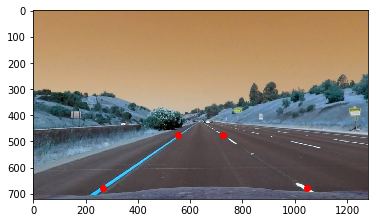

In [6]:
x1 = [265, 680]
x2 = [1045, 680]
x3 = [725, 475]
x4 = [555, 475]
plt.imshow(images[0])
plt.plot([x1[0], x2[0], x3[0], x4[0]], [x1[1], x2[1], x3[1], x4[1]], 'ro')
plt.show()

The warped image now shows the birds-view of the road. In order to get a better crop of the image, the image is now also cropped to the region of interest.

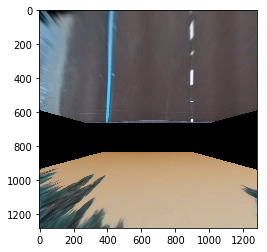

In [7]:
y1 = [400, 650]
y2 = [900, 650]
y3 = [900, 250]
y4 = [400, 250]
image_size = (images[0].shape[1], images[0].shape[1])

src = np.float32([x1, x2, x3, x4])
dst = np.float32([y1, y2, y3, y4])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst,src)
warped = cv2.warpPerspective(images[0], M, image_size, flags=cv2.INTER_LINEAR)

plt.imshow(warped)
plt.show()

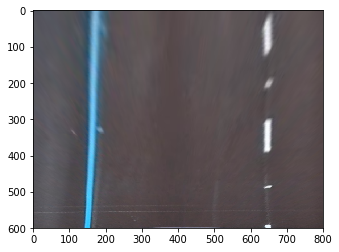

In [8]:
def return_birds_cropped(image):
    warped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    warped_cropped = warped[50:650, 250:1050]
    return warped_cropped

plt.imshow(return_birds_cropped(images[0]))
plt.show()

In [9]:
top_view_images = []
for i, image in enumerate(images):
    top_view_images.append(return_birds_cropped(image))

### Gradient Threshold

The next approach is gradient thresholding using the Sobel Operator. This Algorithm is included in the OpenCV library and will be used here.

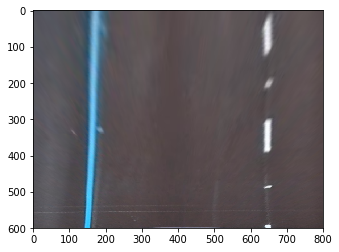

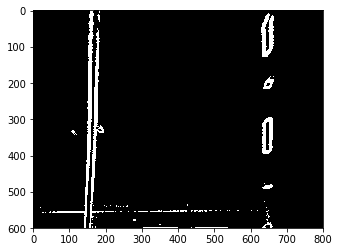

In [10]:
### Set the Thresholds for the Binary Images
mag_thresh = [15, 255]

### prepare the array for the binary thresholded images
images_bthresh = []

### Take the Gradient in X and Y direction for all the images
### And return the magnitude of both.
def mag_threshold(img, sobel_kernel=3, direction='x', mag_thresh=mag_thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if direction=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.abs(sobel)
    scale = np.max(mag)/255
    magxy = (mag/scale).astype(np.uint8)
    thresholded_image = np.zeros_like(mag)
    thresholded_image[(mag <= mag_thresh[1]) & (mag >= mag_thresh[0])] = 1
    return thresholded_image

### Take the Gradient in X and Y direction for all the images
### And return the magnitude of both.
def mag_thresholdxy(img, sobel_kernel=3, mag_thresh=mag_thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    magxy = np.sqrt(sobelx**2 + sobely**2)
    scale = np.max(magxy)/255
    magxy = (magxy/scale).astype(np.uint8)
    thresholded_image = np.zeros_like(magxy)
    thresholded_image[(magxy <= mag_thresh[1]) & (magxy >= mag_thresh[0])] = 1
    return thresholded_image

for image in top_view_images:
    thresholded_image = mag_thresholdxy(image)
    images_bthresh.append(thresholded_image)
    
### Look at a random picture to test
index = np.random.randint(0,images.__len__())
plt.imshow(top_view_images[index])
plt.show()
plt.imshow(images_bthresh[index]*255, cmap='gray')
plt.show()

The gradient Thresholding Shows a good result on most of the images. As a second approach, we will now implement a Sobel Algorithm which will also look at the gradients of the lines, e.g. the angles our lines are located at.
Because we know, that most lane lines should actually be in the range of 30° to 80°, we can actually rule out all other lines.

In [11]:
dir_thresh = [np.pi/6, np.pi/2*8/9]
### The directional threshold function
def dir_threshold(img, sobel_kernel=3, thresh=dir_thresh):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    arctan = np.arctan2(sobely, sobelx)
    binary_output = np.zeros_like(arctan)
    binary_output[(arctan > thresh[0]) & (arctan < thresh[1])] = 1
    return binary_output

Applying all three Threshold Algorithms can yiels a better result than using just one

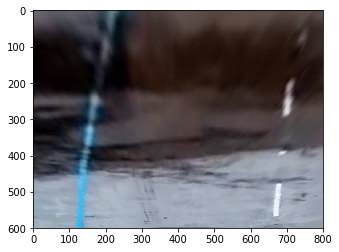

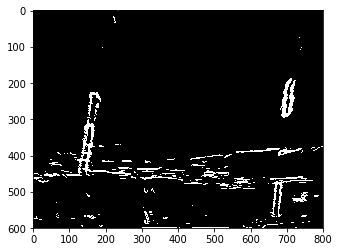

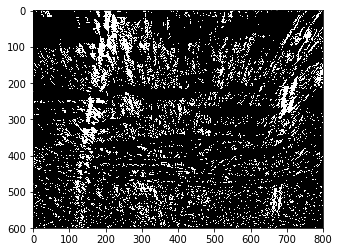

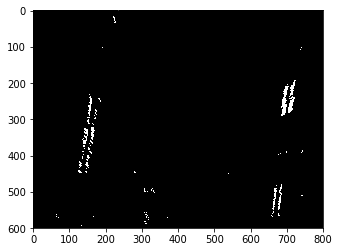

In [12]:
index = 6
show_all = True
thresholded_images = []

def find_total_threshold(image):
    threshold_xy = mag_thresholdxy(image, sobel_kernel=3, mag_thresh=[35, 190])
    threshold_dir = dir_threshold(image, sobel_kernel=3, thresh=[0, 0.3*np.pi/2])
    total_binary = (threshold_xy + threshold_dir) >= 2
    total_binary = total_binary>=1
    if i == index:
        plt.imshow(image)
        plt.show()
        if show_all:
            plt.imshow(threshold_xy*255, cmap='gray')
            plt.show()
            plt.imshow(threshold_dir*255, cmap='gray')
            plt.show()
        plt.imshow(total_binary*255, cmap='gray')
        plt.show()
    return total_binary

for i, image in enumerate(top_view_images):
    total_binary = find_total_threshold(image)
    thresholded_images.append(total_binary)

Adjusting the hyperparameters, in this case the
* Kernel
* Maximum and Minimum Threshold

for each filter seperately was a tideous task. However the output is quite good

### HLS Colorspace

The next step is to convert the images to HLS Colorspace, to get even more information out of them. HLS Colorspace allows to get information based on a mathematical coordinate transform, which display Hue, Light and Saturation instead of RGB Values. Especially the Saturation Space may hold more information to get the lane lines, because they differ significantly from their environment
After numerous tries, I decided to go for the middle value between Light and Saturation. The overlay of both filter, using different thresholds proved to be quite stable.

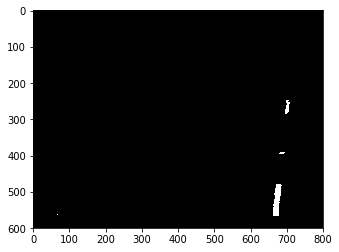

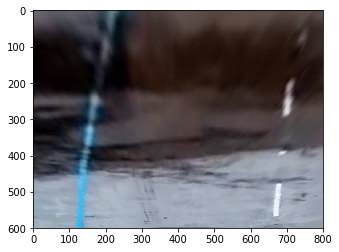

In [13]:
def getL_binary(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    thresh = (200, 255)
    binary1 = np.zeros_like(L)
    binary1[(L > thresh[0]) & (L <= thresh[1])] = 1
    thresh = (200, 255)
    binary2 = np.zeros_like(S)
    binary2[(S > thresh[0]) & (S <= thresh[1])] = 1
    binary = (binary1 + binary2) >= 1
    return binary1

hls_thresh = []
for image in top_view_images:
    Lbin = getL_binary(image)
    hls_thresh.append(Lbin)

plt.imshow(hls_thresh[6], cmap='gray')
plt.show()
plt.imshow(top_view_images[6])
plt.show()

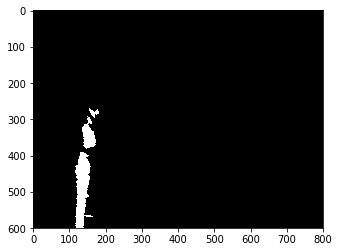

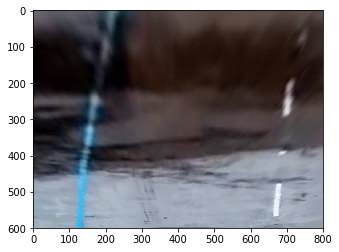

In [14]:
def getB_binary(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L = lab[:,:,0]
    A = lab[:,:,1]
    B = lab[:,:,2]
    thresh = (150, 255)
    binary = np.zeros_like(B)
    binary[(B > thresh[0]) & (B <= thresh[1])] = 1
    return binary

lab_thresh = []
for image in top_view_images:
    Bbin = getB_binary(image)
    lab_thresh.append(Bbin)

plt.imshow(lab_thresh[6], cmap='gray')
plt.show()
plt.imshow(top_view_images[6])
plt.show()

The HLS approach shows good results on all the images. On this particular image above, one can see a small anomaly in the middle of the road. Howver, this shadow can be cropped away, when appliying a cropping filter to the region of interest in the image.

## Combining Both Approaches

When we combine both the HLS filter and the Sobel Thresholding Filters, the resulting image show a good lane quality in the end. Adding up both filtered images gives us a good result for the lane detection algorithm which will follow in the next step

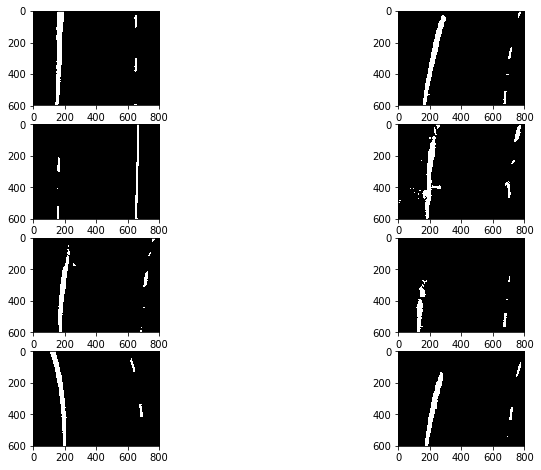

In [15]:
both_threshold = []
for i, thresh_sobel in enumerate(thresholded_images):
    thresh_hls = hls_thresh[i]
    thresh_lab = lab_thresh[i]
    thresh_both = (thresh_hls + 0*thresh_sobel + thresh_lab)
    out_thresh = np.zeros_like(thresh_sobel)
    out_thresh[thresh_both >= 1] = 1
    both_threshold.append(out_thresh)

fig, ax = plt.subplots(4,2, figsize = (12,8))
for i, thresh in enumerate(both_threshold):
    ax[i%4, int(i/4)].imshow(thresh, cmap='gray')
plt.show()

## Application of Histogram to get Lane Pixels

Now we can apply a sliding window histogram to get the lane pixels in the image. Using a histogram of each sliding window, the most outstanding points can be identified as lane pixels, and then an interpolation can find out the actual curvature of the lane ahead.

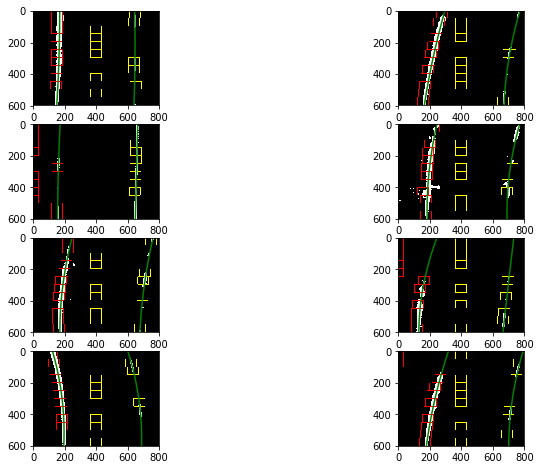

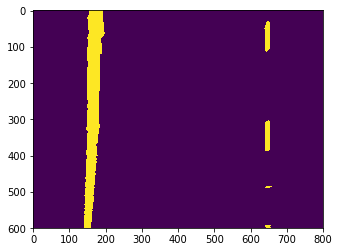

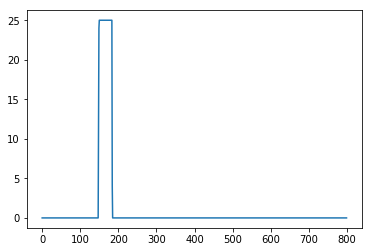

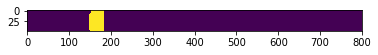

In [16]:
def sliding_window_histogram(image, show=False):
    histogram = np.sum(image[image.shape[0]//2:, :], axis=0)
    mean = np.int(histogram.shape[0]//2)
    
    leftx = np.argmax(histogram[0:mean])
    rightx = np.argmax(histogram[mean:2*mean-1]) + mean
    
    if show:
        plt.plot(histogram)
        plt.plot() 
    return (leftx, rightx)
    
def sliding_window_fit(image):
    h, w = image.shape
    
    # Get the Nonzero Pixels
    points = image.nonzero()
    p_y = np.array(points[0])
    p_x = np.array(points[1])
    
    # Width of Lane Window to Consider
    width_lane = 35
    # Minimum Mount of Pixels in Lane Window to be Considered
    # Relevant
    pix_lane = 150

    left_lane = []
    right_lane = []
    visu_array = []
    for i in range(12):
        # miny, maxy of the current window
        miny = i*50
        maxy = i*50+ 49
        
        # get starting point to find lanes
        lx, rx = sliding_window_histogram(image[miny:maxy, :])
        
        # Set the boundary boxes for the lane finding algorithm
        left = (lx - width_lane, lx + width_lane)
        right = (rx - width_lane, rx + width_lane)
        
        # Append the points for later visualization
        visu_array.append((miny, maxy, left[0], left[1], right[0], right[1]))
        
        # Find the nonzero pixels within our boundary window
        i_left = ((p_y >= miny) & (p_y <= maxy) & (p_x > left[0]) & (p_x < left[1])).nonzero()[0]
        i_right = ((p_y >= miny) & (p_y <= maxy) & (p_x > right[0]) & (p_x < right[1])).nonzero()[0]

        if len(i_left) > pix_lane:
            left_lane.append(i_left)
        if len(i_right) > pix_lane:
            right_lane.append(i_right)
    
    left_lane_fit = None
    right_lane_fit = None
    # Use Numpy's Polyfit funciton to fit a polynomial through the points
    # Get the left and right lane as concatenated list
    if len(left_lane) > 0:
        left_lane = np.concatenate(left_lane)
        left = (p_x[left_lane], p_y[left_lane])
        left_lane_fit = np.polyfit(left[1], left[0], 2)
    if len(right_lane) > 0:
        right_lane = np.concatenate(right_lane)
        right = (p_x[right_lane], p_y[right_lane])
        right_lane_fit = np.polyfit(right[1], right[0], 2)

    return left_lane_fit, right_lane_fit, visu_array

def visualize_lane_finding(image, left_lane, right_lane, visu_array, ax):
    y_axis = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_curve = left_lane[0]*y_axis**2 + left_lane[1]*y_axis + left_lane[2]
    right_curve = right_lane[0]*y_axis**2 + right_lane[1]*y_axis + right_lane[2]
    plot_img = np.uint8(np.dstack((image, image, image))*255)
    for field in visu_array:
        cv2.rectangle(plot_img,(field[2],field[0]),(field[3],field[1]),(255,0,0), 2) 
        cv2.rectangle(plot_img,(field[4],field[0]),(field[5],field[1]),(255,255,0), 2)
    ax.imshow(plot_img)
    ax.plot(left_curve, y_axis, color='green')
    ax.plot(right_curve, y_axis, color='green')
    ax.set_xlim([0,800])
        
fig, ax = plt.subplots(4,2, figsize = (12,8))
left_lanes = []
right_lanes = []
for i, image in enumerate(both_threshold):
    left_lane, right_lane, visu_array = sliding_window_fit(image)
    left_lanes.append(left_lane)
    right_lanes.append(right_lane)
    visualize_lane_finding(image, left_lane, right_lane, visu_array, ax[i%4, int(i/4)])
    
plt.show()

image = both_threshold[0]
plt.imshow(image)
plt.show()

i = 3
slicedImg = image[i*50 : i*50 + 49, :]
sliding_window_histogram(slicedImg, True)

plt.show()
plt.imshow(slicedImg)
plt.show()

Except for image number 5, the lane curves were all well estimaged. In a real world example, the realtime factor could greatly improve the accuracy, based on the fast, that curvatures of lanes don't change that fast.
The information from the previous image can then be used to calculate the current curvature

### Curvature and Distance from Middle of Road

Based on the cropping made to the image, the image point 400 is actually well centered respective to the vehicle.
Using this information, we can calculate the distance from the middle of the road.
Also, based on the assumption, that the cropped area is c.a. 24 Meters long (based on the fact that short lines are 3m and distance in between is 9m, and we have 2 short lines on the reference images). we can actually calculate the curvature of the road.

In [17]:
def calc_curve_metrics(image, left_curve, right_curve):
    # TO calculate the actual point in the road, we can take the
    # Histogram at the very bottom of the image
    dlx, drx = sliding_window_histogram(image[350:600, :])
    middle_point = (dlx + drx)/2
    dist_from_center_px = middle_point-400
    # Average Highway Lane is 3.7 Meters, which corresponds to 500 pixels at the bottom of the image
    scaleX = 3.7/500
    # Lane Line is is 3 Meters long, corresponds to 80px
    scaleY = 3/80
    
    # Calculate the distance from the center
    dist_from_center_cm = dist_from_center_px * scaleX * 100
    
    # Calculate the Curve Radius
    rad_l = ((1 + (2 * left_curve[0] * 600 * scaleY  + left_curve[1])**2)**1.5) / np.abs(2*left_curve[0]) * scaleY
    rad_r = ((1 + (2 * right_curve[0] * 600 * scaleY  + right_curve[1])**2)**1.5) / np.abs(2*right_curve[0]) * scaleY

    return (rad_l, rad_r, dist_from_center_cm)
    
index = 0
calc_curve_metrics(both_threshold[index], left_lanes[index], right_lanes[index])

(344.88618860195612, 416.7204949522785, -4.0700000000000003)

Now that we can calculate the curvature and the distance from the center, we can draw the lanes back to the original images

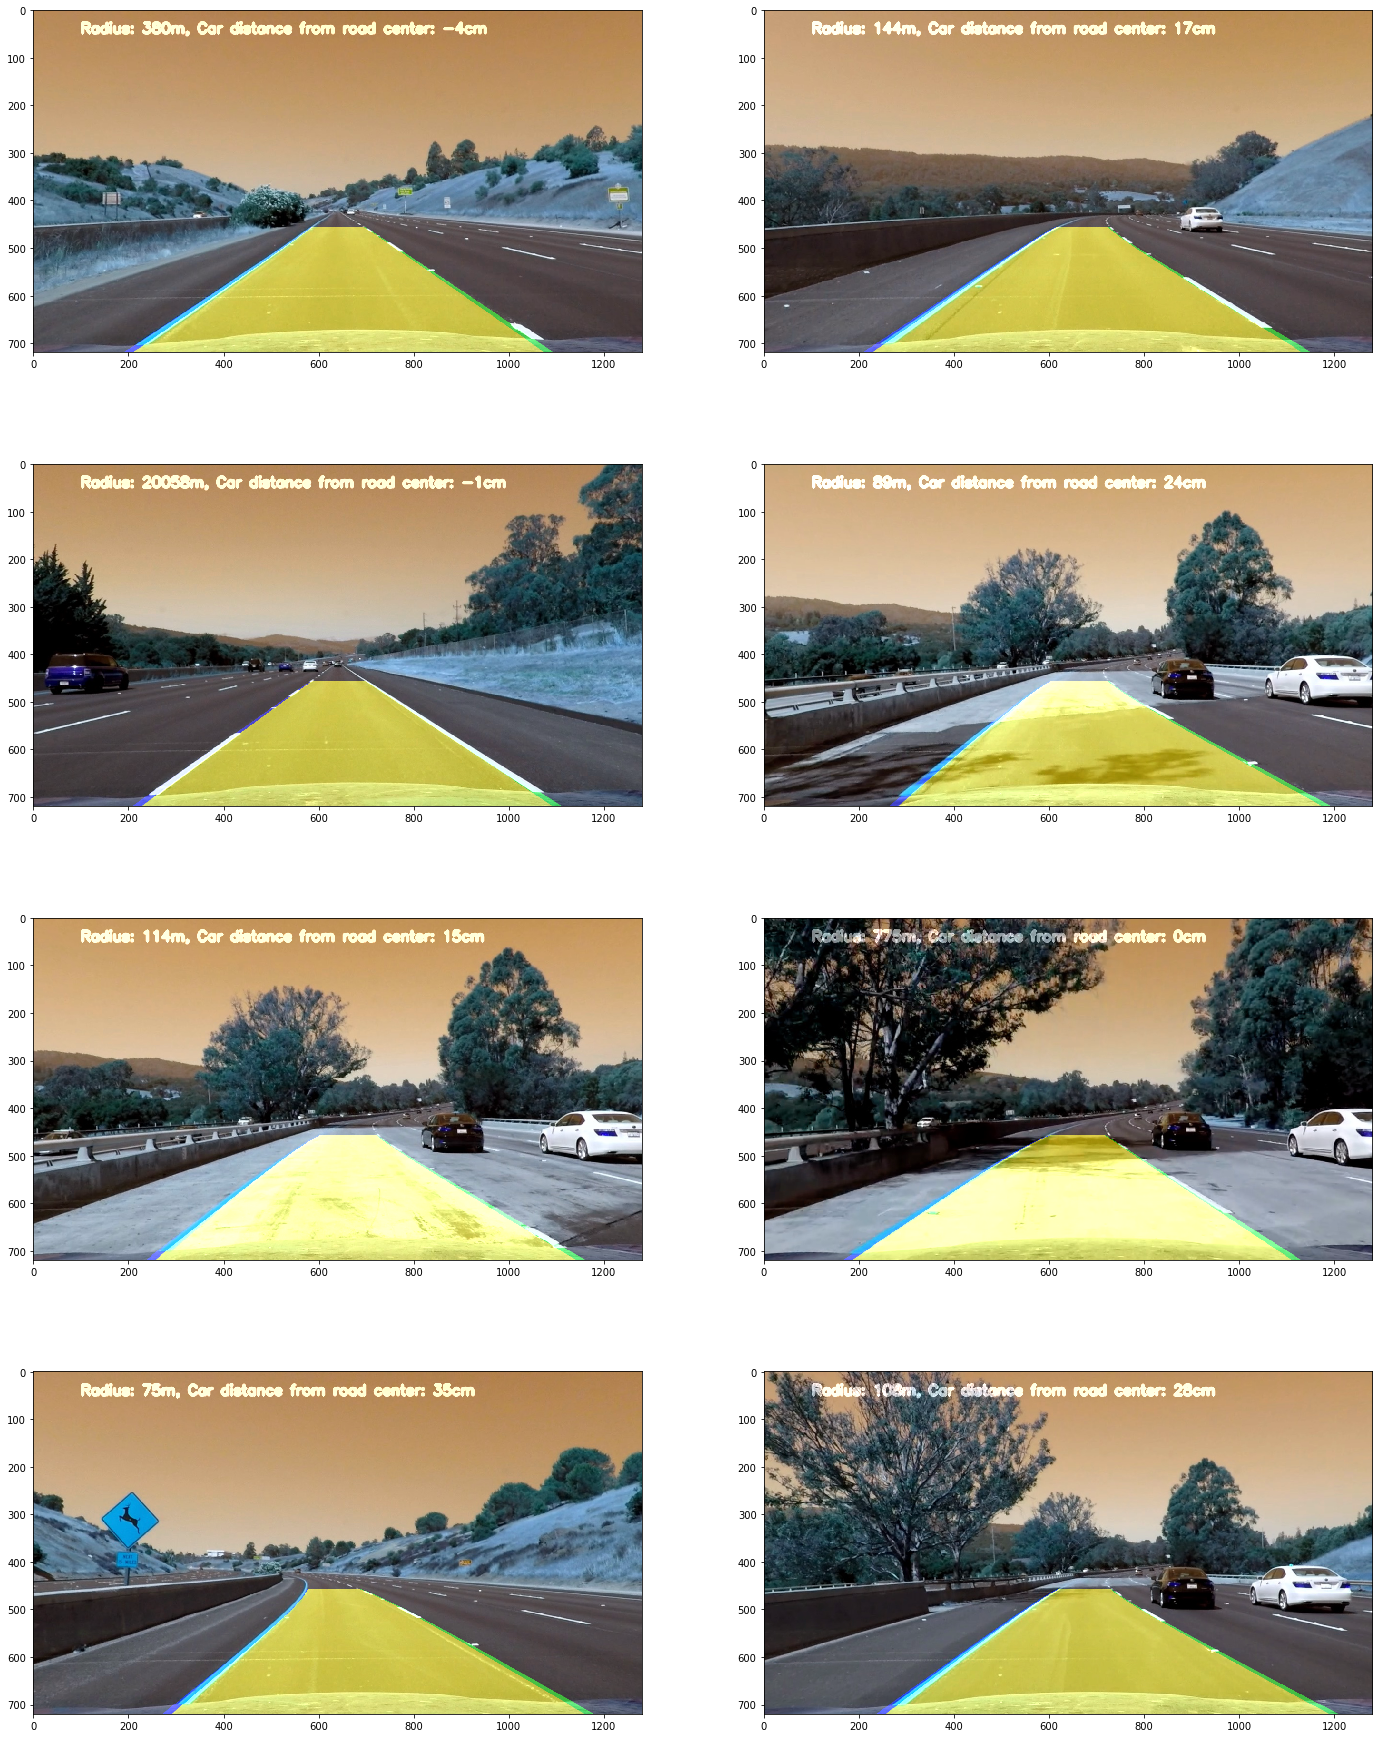

In [21]:
def draw_results_original(orig, thresh, left_lane, right_lane, Minv):
    new = np.copy(orig)
    
    if (left_lane is None) or (right_lane is None):
        return orig
    
    # Create a canvas to draw all our results on,
    # then flip that back to cover the original
    # image
    canvas = np.zeros_like(orig[:,:,0]).astype(np.uint8)
    canvas = np.dstack((canvas, canvas, canvas))
    
    h,w,_ = orig.shape
    
    y_arr = np.linspace(0, h-1, num=h)
    
    left_curve = 250 + left_lane[0]*y_arr**2 + left_lane[1]*y_arr + left_lane[2]
    right_curve = 250 + right_lane[0]*y_arr**2 + right_lane[1]*y_arr + right_lane[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    left_curve_arr = np.array([np.transpose(np.vstack([left_curve, y_arr]))])
    right_curve_arr = np.array([np.flipud(np.transpose(np.vstack([right_curve, y_arr])))])
    curves_arr = np.hstack((left_curve_arr, right_curve_arr))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(canvas, np.int_([curves_arr]), (255,255, 0))
    cv2.polylines(canvas, np.int32([left_curve_arr]), isClosed=False, color=(0,0,255), thickness=10)
    cv2.polylines(canvas, np.int32([right_curve_arr]), isClosed=False, color=(0,255,0), thickness=10)

    # Warp back using inverted matrix
    canvas = cv2.warpPerspective(canvas, Minv, (w, h))
    
    # Calculate the metrics
    rad_l, rad_r, dfc = calc_curve_metrics(thresh, left_lane, right_lane)
    mean_rad = int((rad_l + rad_r)/2)
    
    # Write the metrics to the images
    pict_str = 'Radius: {0}m, Car distance from road center: {1}cm'.format(mean_rad, int(dfc))
    canvas = cv2.putText(canvas, pict_str,(100,50), cv2.FONT_HERSHEY_SIMPLEX, 1., (255,255,255), 5, cv2.LINE_AA)
    
    # Combine the result with the original image
    return cv2.addWeighted(new, 1, canvas, 0.5, 0)


result_images = []
fig, ax = plt.subplots(4,2, figsize = (24,32))
for index,image in enumerate(images):
    result_image = draw_results_original(image, both_threshold[index], left_lanes[index], right_lanes[index], Minv)
    result_images.append(result_image)
    ax[index%4, int(index/4)].imshow(result_image)

The resulting images depict quite well in which direction the road is going. Also, usingthe metrics to calculate the distance from the road center, will allow for additional correction in the steering process

# Pipeline as One Function

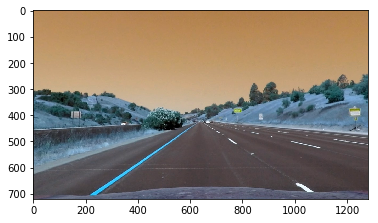

In [27]:
def pipeline(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    birds_view = return_birds_cropped(image)
    LBin = getL_binary(birds_view)
    BBin = getB_binary(birds_view)
    thresh_both = (LBin + BBin)
    thresh_final = np.zeros_like(LBin)
    thresh_final[thresh_both >= 1] = 1
    
    left_lane, right_lane, visu_array = sliding_window_fit(thresh_final)
    result = draw_results_original(image, thresh_final, left_lane, right_lane, Minv)
    return cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
    
plt.imshow(pipeline(images[0]))

# Video Implementation

In the following section, the pipeline will be used to process the video.

In [28]:
from moviepy.editor import VideoFileClip

vidout = 'output.mp4'
vidin = VideoFileClip('project_video.mp4')
processed_video = vidin.fl_image(pipeline)
%time processed_video.write_videofile(vidout, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [00:45<00:00, 27.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Wall time: 45.5 s


In [29]:
from moviepy.editor import VideoFileClip

vidout = 'output_challenge.mp4'
vidin = VideoFileClip('challenge_video.mp4')
processed_video = vidin.fl_image(pipeline)
%time processed_video.write_videofile(vidout, audio=False)

[MoviePy] >>>> Building video output_challenge.mp4
[MoviePy] Writing video output_challenge.mp4


100%|████████████████████████████████████████| 485/485 [00:16<00:00, 30.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_challenge.mp4 

Wall time: 16.7 s


In [30]:
from moviepy.editor import VideoFileClip

vidout = 'output_harder_challenge.mp4'
vidin = VideoFileClip('harder_challenge_video.mp4')
processed_video = vidin.fl_image(pipeline)
%time processed_video.write_videofile(vidout, audio=False)

[MoviePy] >>>> Building video output_harder_challenge.mp4
[MoviePy] Writing video output_harder_challenge.mp4


100%|█████████████████████████████████████▉| 1199/1200 [00:50<00:00, 23.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_harder_challenge.mp4 

Wall time: 51.4 s


# Summary

To summarize this task, most of it has been quite simple.

* Distortion / Undistortion
* Warp / DeWarp
* Understanding the basic Thresholdings

However, getting the right settings for a stable threshold was really hard. This problem boiled down to fine-tune the hyperparameters of the whole pipeline to get a working lane detection.
This hyperparameter tuning was done largely manual, by looking at output images, however, fixing an issue in one image caused an other image to pop up again, with another issue. All in all, I still think that this pipeline is quite fragile and I would need to gather more information on the hyperparameter tuning. However, I think that most of the tuning of the birds-eye image could also be done using machine learning or a neural network. Of course, the data at the moment is not sufficient, but calculating the parameters of the quadratic curve could be a task which could be solved easily with a machine learning algorithm.

The shortcommings of the current approach lie, in my opinion, in its fragile nature. If the lightning conditions change, the current thresholds won't work again. However, one could probably implement an algorithm which adjustst to the lightning conditions, e.g. changes thresholds based on average image light value.

Average Light for Whole Image


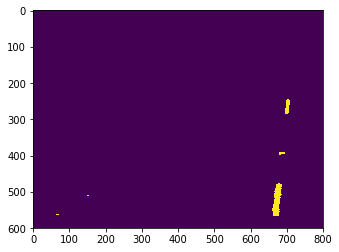

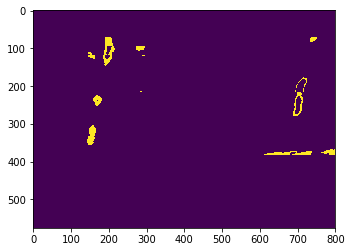

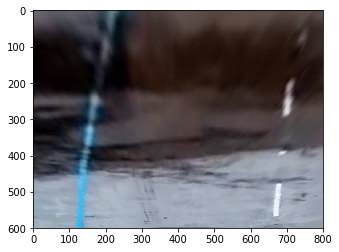

In [62]:
def getL_binary_(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    avgL = np.sum(L)/(image.shape[0]*image.shape[1])
    thresh = (np.min((2.3*avgL,255)), np.min((3*avgL,255)))
    binary = np.zeros_like(L)
    binary[(L > thresh[0]) & (L <= thresh[1])] = 1
    return binary

def getL_binary__(image):
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    avgL = np.sum(L)/(image.shape[0]*image.shape[1])
    thresh = (np.min((2.0*avgL,255)), np.min((3*avgL,255)))
    binary = np.zeros_like(L)
    binary[(L > thresh[0]) & (L <= thresh[1])] = 1
    return binary
    
image = top_view_images[6]
print('Average Light for Whole Image')
out = getL_binary_(image)
plt.imshow(out)
plt.show()

image_out = None
for i in range(24):
    miny = i*25
    maxy = i*25+ 24
    
    out = getL_binary__(image[miny:maxy, :])
    if image_out is None:
        image_out = out
    else:
        image_out = np.vstack((image_out, out))
plt.imshow(image_out)
plt.show()
plt.imshow(top_view_images[6])
plt.show()

Despite this adaptive filter being more computationally expensive (parsing the image by the light value, here simulated by parsing the image line by line), this could prove to be more accurate to find lanes in an image.